In [1]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [42]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
# !rm -rf ./data

In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from albumentations import Compose, Resize, Normalize, Rotate, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, GaussNoise

## loading data

In [45]:
BATCH_SIZE = 128

In [46]:
class FashionMNISTDataset(Dataset):
    def __init__(self, fashionmnist_dataset, transform=None):
        self.fashionmnist_dataset = fashionmnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.fashionmnist_dataset)

    def __getitem__(self, idx):
        image, label = self.fashionmnist_dataset[idx]
        image = np.array(image)[..., None]  # Convert PIL image to numpy array
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [47]:
def get_train_augmentation():
    train_transform = [
        Resize(227, 227),  # Resize images to 227x227
        Normalize(mean=[0.1307], std=[0.3081]),  # Normalize images
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [48]:
def get_val_augmentation():
    train_transform = [
        Rotate(limit=30, p=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        GaussianBlur(blur_limit=5, p=0.3),
        GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        Resize(227, 227),  # Resize images to 227x227
        Normalize(mean=[0.1307], std=[0.3081]),  # Normalize images
        ToTensorV2(),
    ]
    return Compose(train_transform)

In [49]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
                                      
train_set = FashionMNISTDataset(trainset, transform=get_train_augmentation())

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

#test images (with augmentation)
custom_dataset = FashionMNISTDataset(testset, transform=get_val_augmentation())

# Create a DataLoader
testloader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [52]:
len(trainloader)

469

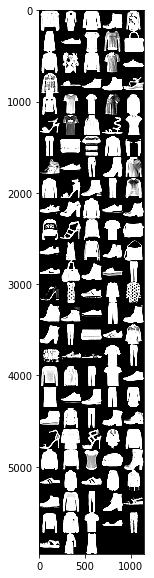

In [53]:
#train images (no augmentation)
images, labels = next(iter(trainloader))
grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

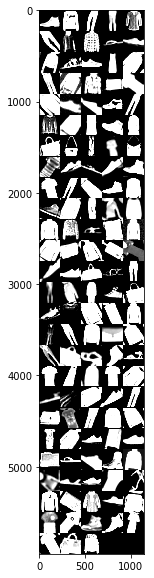

In [54]:
# Visualize some images
images, labels = next(iter(testloader))
grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.figure(figsize=(15,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## model

In [55]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out

In [56]:
LEARNING_RATE = 0.001
EPOCHS = 10

In [57]:
model = AlexNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# fitting our neural network

In [58]:
epochs = EPOCHS
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_acc += (preds == target).float().mean().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(running_acc / len(trainloader))

    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_acc += (preds == target).float().mean().item()

    test_loss.append(running_loss / len(testloader))
    test_acc.append(running_acc / len(testloader))

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, "
          f"Test Loss: {test_loss[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}")


Epoch 1, Train Loss: 0.612, Train Acc: 0.774, Test Loss: 1.336, Test Acc: 0.574



Epoch 2, Train Loss: 0.338, Train Acc: 0.875, Test Loss: 1.525, Test Acc: 0.557



Epoch 3, Train Loss: 0.299, Train Acc: 0.890, Test Loss: 1.411, Test Acc: 0.584



Epoch 4, Train Loss: 0.272, Train Acc: 0.899, Test Loss: 1.495, Test Acc: 0.574



Epoch 5, Train Loss: 0.258, Train Acc: 0.905, Test Loss: 1.576, Test Acc: 0.571



Epoch 6, Train Loss: 0.238, Train Acc: 0.913, Test Loss: 1.468, Test Acc: 0.591



Epoch 7, Train Loss: 0.225, Train Acc: 0.917, Test Loss: 1.536, Test Acc: 0.585



Epoch 8, Train Loss: 0.216, Train Acc: 0.920, Test Loss: 1.807, Test Acc: 0.574



Epoch 9, Train Loss: 0.201, Train Acc: 0.925, Test Loss: 1.726, Test Acc: 0.583



Epoch 10, Train Loss: 0.194, Train Acc: 0.927, Test Loss: 1.501, Test Acc: 0.604


# building graphics

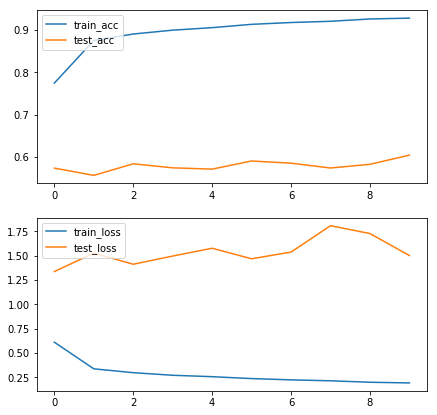

In [62]:
fig = plt.figure(figsize=[7, 7])
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
ax1.plot(train_acc, label="train_acc")
ax1.plot(test_acc, label="test_acc")
ax1.legend(loc=2)
ax2.plot(train_loss, label="train_loss")
ax2.plot(test_loss, label="test_loss")
ax2.legend(loc=2)
plt.show()